In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle

import mlrfit as mf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 30
mtype = 'assetcov_gics'

with open("../data_finance/crsp_gics_5k_hpart.pkl", "rb") as f:
       gics_hpart = pickle.load(f)

with open('../data_finance/crsp_gics_5k_C.npy', 'rb') as f:
       C = np.load(f)

m = n = gics_hpart['rows']['pi'].size
for level in range(len(gics_hpart['rows']['lk'])):
    print(f"{level=}, {gics_hpart['rows']['lk'][level].size-1}")

Z = mf.demean_clip(C)
A = Z @ Z.T / (Z.shape[1]-1)

level=0, 1
level=1, 11
level=2, 24
level=3, 69
level=4, 157
level=5, 5000


In [4]:
U, Vt, sigmas = mf.frob_low_rank(A)
frob_losses = np.zeros(m)
normalization = np.linalg.norm(A, ord='fro')
# assert np.allclose(normalization, ((sigmas**2).sum())**0.5)
sigmas2 = (sigmas**2)[::-1]
frob_losses = np.concatenate([(np.cumsum(sigmas2)**0.5)[::-1][1:] / normalization, np.array([0])])

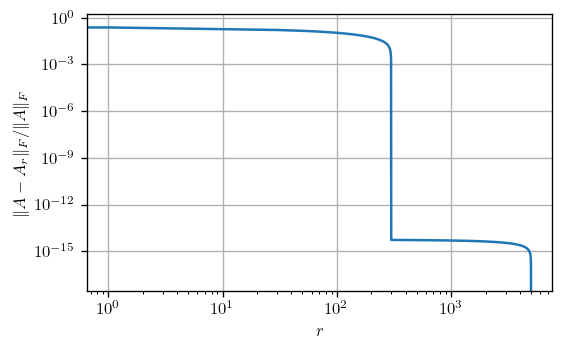

In [5]:
mf.plot_frob_error_rank(frob_losses)

In [6]:
C.shape, A.shape, A.min(), A.max(), A.mean(), A.std()

((5000, 300),
 (5000, 5000),
 -0.0018394775345592505,
 0.014836883129622934,
 0.0002737358427138843,
 0.00025728376347159727)

In [7]:
eps_ff = 1e-2
eps = 1e-3

In [8]:
method = 'bcd'
svds_v0 = True
max_iters_ff = 2
max_iters = 3*10**3
PSD = True
symm = True

filename = "%s_r%d_%d"%(mtype, rank, n)

# Rank allocation + spectral partitioning + greedy refinement

In [9]:
info = {} 

In [10]:
# LR
hpart = mf.random_hpartition(m, n, num_levels=1, symm=symm, perm=False)
B1, C1 = mf.single_level_factor_fit(A, np.array([rank]), hpart, level=0, symm=symm, PSD=PSD)[:2]
info['LR'] = {'loss':[mf.rel_diff(B1 @C1.T, den=A)]}
print(info['LR']['loss'])

[0.16178478761767232]


In [11]:
# LR+D fitting
hpart = mf.random_hpartition(m, n, level_list=[0, int(np.log2(m))+1], symm=symm, perm=False)
assert hpart['rows']['lk'][1].size == min(m,n)+1
ranks = np.array([rank-1, 1])
hat_A = mf.MLRMatrix(hpart=hpart, ranks=ranks)
start_time = time.time()
fa_losses = hat_A.factor_fit(A, ranks, hat_A.hpart, method=method, eps_ff=eps_ff/10000, \
                                  freq=100, svds_v0=svds_v0,\
                                  printing=False, max_iters_ff=max_iters, symm=symm, warm_start=False)
fa_time = time.time()-start_time
info['LR+D'] = {'loss':fa_losses, 'time':fa_time}
print(f"{fa_losses[-1]=} {len(fa_losses)} time={fa_time:.3f}")

/Users/parshakova.tanya/Documents/mlr_fitting/mlrfit/utils.py:404: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


fa_losses[-1]=0.1537922868665804 6 time=55.460


In [12]:
# GICS hierarchy
num_levels = len(gics_hpart['rows']['lk'])

In [13]:
# uniform rank initialization + GICS hierarchy + rank allocation
ranks = mf.uniform_ranks(rank, num_levels) 
print(ranks)
hat_A = mf.MLRMatrix(hpart=gics_hpart, ranks=ranks)
start_time = time.time()
ra_losses, epochs, ranks_history_uni = hat_A.rank_alloc(A, ranks, hat_A.hpart, freq=1,\
                        eps=eps, eps_ff=eps_ff, max_iters=max_iters, PSD=PSD, symm=symm,\
                        max_iters_ff=max_iters_ff, warm_start=False)
ra_time = time.time()-start_time
info['MLR uniform'] = {'loss':ra_losses, 'ra_time':ra_time, 'epochs':epochs}
print(f"td+ra time={ra_time:.3f}")

[5 5 5 5 5 5]
itr=0, t=3, losses[0]=0.18304971186124508, losses[-1]=0.18115165653212797, [5 5 5 5 5 5]
itr=1, t=6, 0.17760319373154995, [6 5 5 5 5 4]
itr=2, t=9, 0.17526203538344337, [7 5 5 5 5 3]
itr=3, t=12, 0.17320062948232995, [8 5 5 5 5 2]
itr=4, t=15, 0.17123781655475356, [9 5 5 5 5 1]
itr=5, t=18, 0.16976666828550335, [10  5  5  5  4  1]
itr=6, t=21, 0.1683443592560673, [11  5  5  5  3  1]
itr=7, t=24, 0.16699033223213045, [12  5  5  4  3  1]
itr=8, t=27, 0.1658319270936777, [13  5  5  4  2  1]
itr=9, t=30, 0.16473492603709036, [14  5  5  3  2  1]
itr=10, t=33, 0.16369949161116465, [15  5  5  3  1  1]
itr=11, t=36, 0.16271825209289337, [16  5  5  2  1  1]
itr=12, t=39, 0.16183771490312615, [17  5  4  2  1  1]
itr=13, t=42, 0.1609730679688495, [18  5  3  2  1  1]
itr=14, t=45, 0.16005469382701504, [19  5  3  1  1  1]
itr=15, t=48, 0.1592639628654469, [20  5  2  1  1  1]
itr=16, t=51, 0.15860377442339196, [21  4  2  1  1  1]
itr=17, t=54, 0.15789430844667762, [22  3  2  1  1  1]
i

In [14]:
# bottom rank initialization + GICS hierarchy + rank allocation
ranks = np.array((num_levels-1)*[0]+[rank]) 
print(ranks)
hat_A = mf.MLRMatrix(hpart=gics_hpart, ranks=ranks)
start_time = time.time()
ra_losses, epochs, ranks_history_bottom = hat_A.rank_alloc(A, ranks, hat_A.hpart, freq=1,\
                        eps=eps, eps_ff=eps_ff, max_iters=max_iters, PSD=PSD, symm=symm,\
                        max_iters_ff=max_iters_ff, warm_start=False)
ra_time = time.time()-start_time
info['MLR bottom'] = {'loss':ra_losses, 'ra_time':ra_time, 'epochs':epochs}
print(f"td+ra time={ra_time:.3f}")

[ 0  0  0  0  0 30]
itr=0, t=3, losses[0]=0.9964034275153691, losses[-1]=0.9964034275153691, [ 0  0  0  0  0 30]
itr=1, t=6, 0.25789623933139616, [ 1  0  0  0  0 29]
itr=2, t=9, 0.22336450751609954, [ 2  0  0  0  0 28]
itr=3, t=12, 0.20445675337736138, [ 3  0  0  0  0 27]
itr=4, t=15, 0.1959904016189144, [ 4  0  0  0  0 26]
itr=5, t=18, 0.1904434327633549, [ 5  0  0  0  0 25]
itr=6, t=21, 0.18578546720178915, [ 6  0  0  0  0 24]
itr=7, t=24, 0.18289954291436586, [ 7  0  0  0  0 23]
itr=8, t=27, 0.18053266891609757, [ 8  0  0  0  0 22]
itr=9, t=30, 0.17831097103325927, [ 9  0  0  0  0 21]
itr=10, t=33, 0.1763781102590341, [10  0  0  0  0 20]
itr=11, t=36, 0.17466271344630813, [11  0  0  0  0 19]
itr=12, t=39, 0.17297096622362212, [12  0  0  0  0 18]
itr=13, t=42, 0.17158598680520312, [13  0  0  0  0 17]
itr=14, t=45, 0.17027252180523023, [14  0  0  0  0 16]
itr=15, t=48, 0.1689720247460934, [15  0  0  0  0 15]
itr=16, t=51, 0.1677186255495341, [16  0  0  0  0 14]
itr=17, t=54, 0.1664785

In [15]:
# top rank initialization + GICS hierarchy + rank allocation
ranks = np.array([rank]+(num_levels-1)*[0])
print(ranks)
hat_A = mf.MLRMatrix(hpart=gics_hpart, ranks=ranks)
start_time = time.time()
ra_losses, epochs, ranks_history_top = hat_A.rank_alloc(A, ranks, hat_A.hpart, freq=1,\
                        eps=eps, eps_ff=eps_ff, max_iters=max_iters, PSD=PSD, symm=symm,\
                        max_iters_ff=max_iters_ff, warm_start=False)
ra_time = time.time()-start_time
info['MLR top'] = {'loss':ra_losses, 'ra_time':ra_time, 'epochs':epochs}
print(f"td+ra time={ra_time:.3f}")

[30  0  0  0  0  0]
itr=0, t=3, losses[0]=0.16178478761767176, losses[-1]=0.16178478761767173, [30  0  0  0  0  0]
itr=1, t=6, 0.15379235716161116, [29  0  0  0  0  1]
quit: new rank allocation is worse
itr=2, t=9, 0.15379228616060095, [29  0  0  0  0  1]
td+ra time=226.239


In [16]:
# mf.plot_loss_all_info(info, figsize=(7, 5), dpi=120, logscale=False, hline=True, ylim=[0.14, 0.3], filename='')

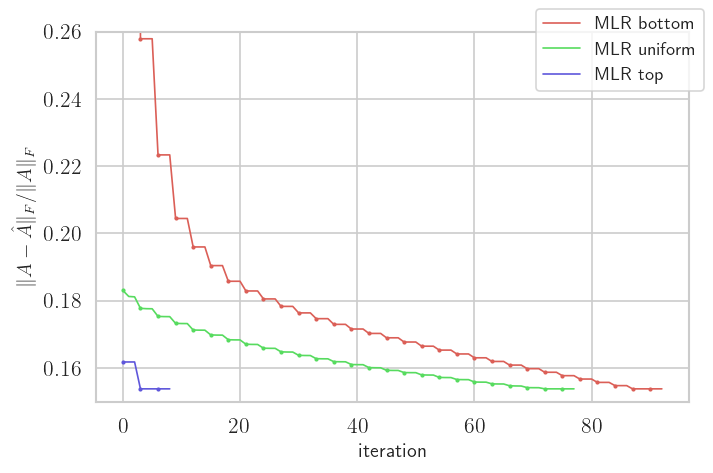

In [17]:
mf.plot_loss_all_info(info, labels=['MLR bottom', 'MLR uniform', 'MLR top'], figsize=(6, 4), dpi=120, \
                        logscale=False, hline=False, ylim=[0.15, 0.26], filename="plots/loss_%s.pdf"%filename)

In [18]:
for i, algo in enumerate(info.keys()):
    print(f"{algo:14s} {info[algo]['loss'][-1]}")

LR             0.16178478761767232
LR+D           0.1537922868665804
MLR uniform    0.15379228615265847
MLR bottom     0.15379228605054865
MLR top        0.15379228616060095


In [19]:
with open('outputs/info_%s.pickle'%filename, 'wb') as handle:
    pickle.dump(info, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
rh_top = np.stack(ranks_history_top, axis=0)
rh_bot = np.stack(ranks_history_bottom, axis=0)
rh_uni = np.stack(ranks_history_uni, axis=0)

with open('outputs/ranks_%s.pickle'%filename, 'wb') as handle:
    pickle.dump([rh_bot, rh_uni, rh_top], handle, protocol=pickle.HIGHEST_PROTOCOL)

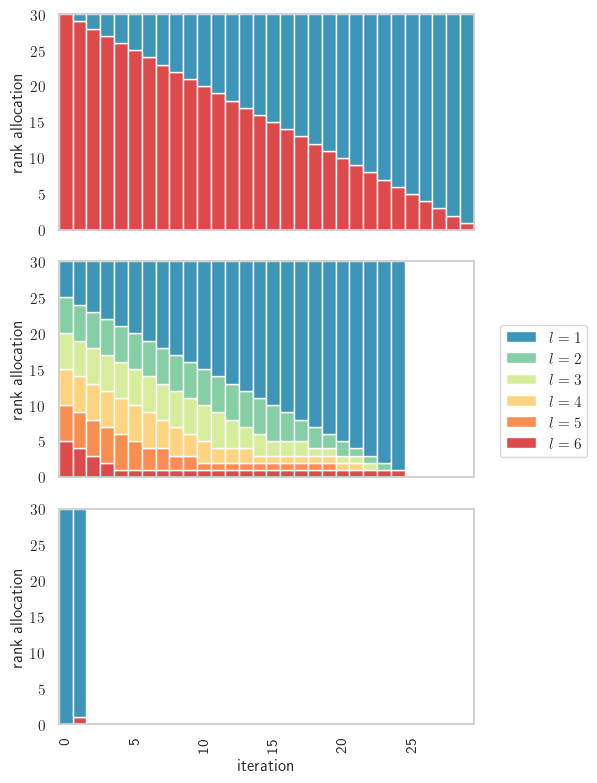

In [21]:
mf.plot_ra_evolution_col([rh_bot, rh_uni, rh_top],  dpi=100, figsize=(5, 8)) #filename="plots/ra_%s.pdf"%filename)